In [1]:
import os
#%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
plt.style.use('seaborn-v0_8-deep')

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    #"font.size"   : 15,
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
})

LABELS = ["sgd", "rmiso", "adam", "mcsag", "adagrad", "sgd_lr_decay"]

In [2]:
def get_folder_path(use_pretrained=True):
    path = 'curve'
    if use_pretrained:
        path = os.path.join(path, 'pretrained')
    return path

In [3]:
def get_curve_data(use_pretrained=True, dataset='synthetic'):
    folder_path = get_folder_path(use_pretrained)
    filenames = [name for name in os.listdir(folder_path) if name.startswith(dataset.lower())]
    paths = [os.path.join(folder_path, name) for name in filenames]
    optims = [name.split('-')[2] for name in filenames]
    lrs = [float(name.split('-')[3][2:]) for name in filenames]
    algs = [name.split('-')[-1] for name in filenames]
    nodes = [int(name.split('-')[-5][6:]) for name in filenames]
    edges = [int(name.split('-')[-4][5:]) for name in filenames]
    hyperparams = [name.split('-')[4:-5] for name in filenames]
    return [{"optim": op, "lr": l, "alg": alg, "hyp_params": hp, "nodes": nodes, "edges": edges, "curve": torch.load(fp)}
            for op, l, alg, hp, nodes, edges, fp in zip(optims, lrs, algs, hyperparams, nodes, edges, paths)]

In [4]:
def order_labels(labels, handels):
    idx1 = labels.index("RMISO-CPR")
    cpr = labels.pop(idx1), handels.pop(idx1)
    idx2 = labels.index("RMISO-DPR")
    dpr = labels.pop(idx2), handels.pop(idx2)
    
    zipped = zip(labels, handels)
    zipped = sorted(zipped, key=lambda x: x[0])
    handels = [handel for (label, handel) in zipped]
    labels = [label for (label, handel) in zipped]
    handels = [cpr[1], dpr[1]] + handels
    labels = [cpr[0], dpr[0]] + labels
        
            
        
    return handels, labels

In [127]:
def plot_lonely(use_pretrained=True, dataset='synthetic', optimizers=None, title=None, ylim=(60, 80), xlim=(0, 10000), curve_type='train',
         algorithm='uniform', display_hyperparams=False, creg=1, dreg=1, t_hit=50):
    assert curve_type in ['train_acc', 'test_acc', 'train_loss', 'test_loss'], 'Invalid curve type: {}'.format(curve_type)
    assert all(_ in LABELS for _ in optimizers), 'Invalid optimizer'
    
    curve_data = get_curve_data(use_pretrained, dataset=dataset)
    
    #plt.figure()
    fig, ax = plt.subplots(figsize=(4,4.5),sharex=True, sharey=True, tight_layout=True)
    if curve_type.split("_")[1] == "acc":
        if title is None:
            title = '{} Accurcy on {}'.format(curve_type.split("_")[0].capitalize(), dataset)
        plt.ylabel('{} Accuracy'.format(curve_type.split("_")[0].capitalize()), fontsize=14)
    else:
        if title is None:
            title = '{} Loss on {}'.format(curve_type.split("_")[0].capitalize(), dataset)
        plt.ylabel('{} Loss'.format(curve_type.split("_")[0].capitalize()), fontsize=14)

    #plt.title(title)
    plt.xlabel('Iterations', fontsize=14)
    plt.xlim(xlim)
    plt.ylim(ylim)
    for curve in curve_data:
        optim = curve['optim']
        lr = curve['lr']
        alg = curve['alg']
        if curve['edges'] != 1177:
            continue
        
        if optim == "rmiso":
            try:
                dynamic = curve['hyp_params'][1][8:] == 'True'
                dr = curve['hyp_params'][2][3:] == 'True'
            except ValueError:
                dynamic = False
                dr = False
            rho = curve['hyp_params'][0][3:]
            
        #if optim == "mcsag" and float(delta) != 1:
            #continue
        
        linestyle = '-' if 'rmiso' in optim else '-'
        marker = '*' if 'rmiso' in optim else ''
        
        
        if optim in optimizers.keys() and lr in optimizers[optim] and alg == algorithm:
            accuracies = np.array(curve['curve'][curve_type])
            n_iterations = np.array(curve['curve']['iter_count'])
            if optim == "rmiso":
                version = {dr: "dr", dynamic: "dpr", not (dynamic or dr): "cpr"}[True]
                style_dict = {"dr": {'color': '#9a0200', 'label': 'RMISO-DR'},
                              "dpr": {'color': '#dd8452', 'label': 'RMISO-DPR'},
                               "cpr": {'color': '#55a868', 'label': 'RMISO-CPR'}}
                color = '#dd8452' if dynamic else '#55a868'
                color = style_dict[version]['color']
                label = style_dict[version]['label']
                L = 1/lr
            elif optim == "sgd":
                label = "SGD-HB: lr={}".format(lr) if display_hyperparams else "SGD-HB"
                color = '#4c72b0'
            elif optim == "sgd_lr_decay":
                label = "SGD: lr={}".format(lr) if display_hyperparams else "SGD"
                color = '#64b5cd'
            elif optim =="mcsag":
                color = '#ccb974'
                if alg == 'uniform':
                    label = "SAG-lr: {}".format(lr)
                else:
                    tau = curve['hyp_params'][1][3:]
                    label = r'MCSAG-lr: {}, $\beta={}$'.format(lr, delta) if display_hyperparams else "MCSAG"
            else:
                color = '#8172b3'
                label = f"{optim.upper()}, lr={lr}" if display_hyperparams else f"{optim.upper()}"
            if optim == 'mcsag':
                if float(tau) == t_hit:
                    ax.plot(n_iterations, accuracies, label=label, linewidth=2, markersize=10, color=color, ls=linestyle, marker=marker, markevery=20, zorder=0)
                else:
                    continue
            elif optim == "rmiso":
                if (float(rho) == creg and not dynamic) or (float(rho) == dreg and dynamic) or dr :
                    ax.plot(n_iterations, accuracies, label=label, linewidth=2, markersize=10, ls=linestyle, marker=marker, color=color, markevery=20, zorder=1)
                else:
                    continue
            else:
                ax.plot(n_iterations, accuracies, label=label, linewidth=2, markersize=10, ls=linestyle, color=color, marker=marker, markevery=20, zorder=0)
                
        

        
    plt.grid(ls='--')
    handles,labels = plt.gca().get_legend_handles_labels()
    handles, labels = order_labels(labels, handles)
    plt.legend(handles, labels, ncol=2, fontsize=11, loc='upper center')
    fig.tight_layout()
    #plt.show()
    save_name = "{}_{}_{}_lonely".format(dataset, curve_type, algorithm)+"_icml.eps" 
    path = os.path.join(os.getcwd(), 'figs')
    os.makedirs(path, exist_ok=True)
    f_name = os.path.join(path, save_name)
    #plt.savefig(f_name, format='eps', dpi=5000)

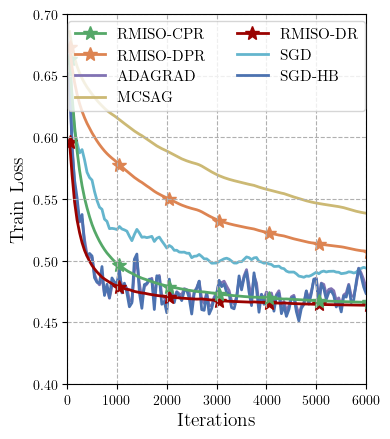

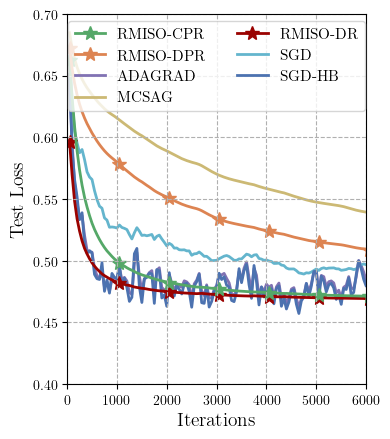

In [136]:
optimizers = {"rmiso": [1], "sgd": [0.05], "sgd_lr_decay": [0.1], 'mcsag':[1], "adagrad": [0.05]}
creg = 50
dreg=50
t_hit = 50

plot_lonely(use_pretrained=False, dataset='a9a',
     title=None, optimizers=optimizers, ylim=(0.4, 0.7), xlim=(0, 6000), curve_type='train_loss', algorithm="random_walk", creg=creg, dreg=dreg, t_hit=t_hit)
plot_lonely(use_pretrained=False, dataset='a9a',
     title=None, optimizers=optimizers, ylim=(0.4, 0.7), xlim=(0, 6000), curve_type='test_loss', algorithm="random_walk", creg=creg, dreg=dreg, t_hit=t_hit)

In [111]:
def plot_complete(use_pretrained=True, dataset='synthetic', optimizers=None, title=None, ylim=(60, 80), xlim=(0, 10000), curve_type='train',
         algorithm='uniform', display_hyperparams=False, creg=1, dreg=1, t_hit=50):
    assert curve_type in ['train_acc', 'test_acc', 'train_loss', 'test_loss'], 'Invalid curve type: {}'.format(curve_type)
    assert all(_ in LABELS for _ in optimizers), 'Invalid optimizer'
    
    curve_data = get_curve_data(use_pretrained, dataset=dataset)
    
    #plt.figure()
    fig, ax = plt.subplots(figsize=(4,4.5),sharex=True, sharey=True, tight_layout=True)
    if curve_type.split("_")[1] == "acc":
        if title is None:
            title = '{} Accurcy on {}'.format(curve_type.split("_")[0].capitalize(), dataset)
        plt.ylabel('{} Accuracy'.format(curve_type.split("_")[0].capitalize()), fontsize=14)
    else:
        if title is None:
            title = '{} Loss on {}'.format(curve_type.split("_")[0].capitalize(), dataset)
        plt.ylabel('{} Loss'.format(curve_type.split("_")[0].capitalize()), fontsize=14)

    #plt.title(title)
    plt.xlabel('Iterations', fontsize=14)
    plt.xlim(xlim)
    plt.ylim(ylim)
    for curve in curve_data:
        optim = curve['optim']
        lr = curve['lr']
        alg = curve['alg']
        if curve['edges'] != 50*49/2:
            continue
        
        if optim == "rmiso":
            try:
                dynamic = curve['hyp_params'][1][8:] == 'True'
                dr = curve['hyp_params'][2][3:] == 'True'
            except ValueError:
                dynamic = False
                dr = False
            rho = curve['hyp_params'][0][3:]
            
        #if optim == "mcsag" and float(delta) != 1:
            #continue
        
        linestyle = '-' if 'rmiso' in optim else '-'
        marker = '*' if 'rmiso' in optim else ''
        
        
        if optim in optimizers.keys() and lr in optimizers[optim] and alg == algorithm:
            accuracies = np.array(curve['curve'][curve_type])
            n_iterations = np.array(curve['curve']['iter_count'])
            if optim == "rmiso":
                version = {dr: "dr", dynamic: "dpr", not (dynamic or dr): "cpr"}[True]
                style_dict = {"dr": {'color': '#9a0200', 'label': 'RMISO-DR'},
                              "dpr": {'color': '#dd8452', 'label': 'RMISO-DPR'},
                               "cpr": {'color': '#55a868', 'label': 'RMISO-CPR'}}
                color = '#dd8452' if dynamic else '#55a868'
                color = style_dict[version]['color']
                label = style_dict[version]['label']
                L = 1/lr
                #label = "RMISO-DPR" if dynamic else "RMISO-CPR"
            elif optim == "sgd":
                label = "SGD-HB: lr={}".format(lr) if display_hyperparams else "SGD-HB"
                color = '#4c72b0'
            elif optim == "sgd_lr_decay":
                label = "SGD: lr={}".format(lr) if display_hyperparams else "SGD"
                color = '#64b5cd'
            elif optim =="mcsag":
                color = '#ccb974'
                if alg == 'uniform':
                    label = "SAG-lr: {}".format(lr)
                else:
                    tau = curve['hyp_params'][1][3:]
                    label = r'MCSAG-lr: {}, $\beta={}$'.format(lr, delta) if display_hyperparams else "MCSAG"
            else:
                color = '#8172b3'
                label = f"{optim.upper()}, lr={lr}" if display_hyperparams else f"{optim.upper()}"
            if optim == 'mcsag':
                if float(tau) == t_hit:
                    ax.plot(n_iterations, accuracies, label=label, color=color, linewidth=2, markersize=10, ls=linestyle, marker=marker, markevery=20, zorder=0)
                else:
                    continue
            elif optim == "rmiso":
                if (float(rho) == creg and not dynamic) or (float(rho) == dreg and dynamic) or dr:
                    ax.plot(n_iterations, accuracies, label=label, ls=linestyle, linewidth=2, markersize=10, marker=marker, color=color, markevery=20, zorder=1)
                else:
                    continue
            else:
                ax.plot(n_iterations, accuracies, label=label, ls=linestyle, linewidth=2, markersize=10, color=color, marker=marker, markevery=20, zorder=0)
                
        

        
    plt.grid(ls='--')
    handles,labels = plt.gca().get_legend_handles_labels()
    handles, labels = order_labels(labels, handles)
    plt.legend(handles, labels, ncol=2, fontsize=11)
    fig.tight_layout()
    #plt.show()
    save_name = "{}_{}_{}_complete".format(dataset, curve_type, algorithm)+"_icml.eps" 
    path = os.path.join(os.getcwd(), 'figs')
    os.makedirs(path, exist_ok=True)
    f_name = os.path.join(path, save_name)
    #plt.savefig(f_name, format='eps', dpi=5000)

dr
cpr
dpr
dr
cpr
dpr


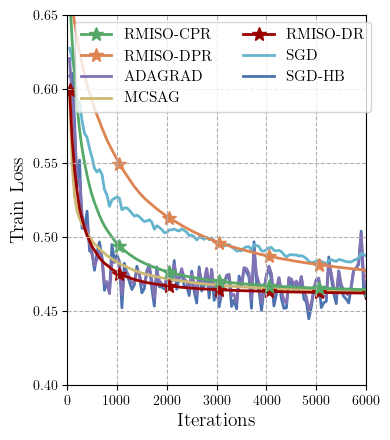

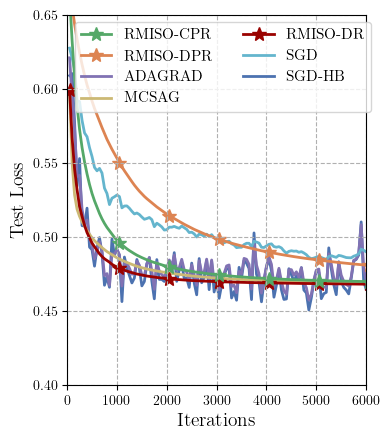

In [134]:
optimizers = {"rmiso": [1], "sgd": [0.05], "sgd_lr_decay": [0.1], 'mcsag':[2.5], "adagrad": [0.05]}
creg = 50
dreg=50
t_hit = 50

plot_complete(use_pretrained=False, dataset='a9a',
     title=None, optimizers=optimizers, ylim=(0.4, 0.65), xlim=(0, 6000), curve_type='train_loss', algorithm="random_walk", creg=creg, dreg=dreg, t_hit=t_hit)
plot_complete(use_pretrained=False, dataset='a9a',
     title=None, optimizers=optimizers, ylim=(0.4, 0.65), xlim=(0, 6000), curve_type='test_loss', algorithm="random_walk", creg=creg, dreg=dreg, t_hit=t_hit)

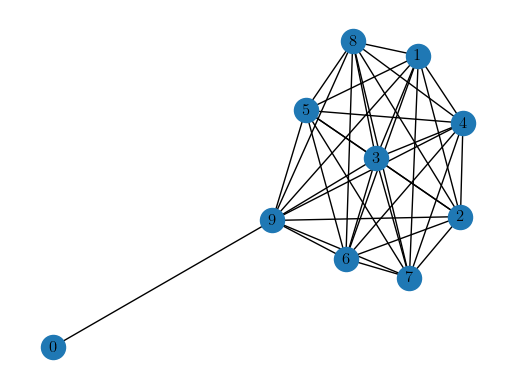

In [8]:
from graph_structure.data_graph import plot_graph
fig, ax = plot_graph(nodes=10, radius=0.3, topo='lonely')